In [1]:
import matplotlib.pyplot as pt
import matplotlib.image
import numpy as np
import cv2

In [137]:

def show(*args, labels=[], show_axis=False, figsize=(10, 5), save_to: str = None):
    l = len(args)

    if len(labels) < l:
        labels += [None] * (l - len(labels))

    # fg, plots = pt.subplots(int(l ** .5), l // int(l ** .5), figsize=figsize)
    fg, plots = pt.subplots(1, l, figsize=figsize)

    try:
        plots = plots.flatten()
    except:
        plots = [plots]

    for m, p, l in zip(args, plots, labels):
        ax = p.imshow(m)

        if not show_axis:
            ax.axes.axis('off')

        if l:
            ax.axes.title.set_text(l)

    if save_to is not None:
        pt.savefig(save_to)


In [3]:
# READ MASK

KERN = np.ones((3, 3), dtype=np.uint8)

image_id = "medium_density_mango_7"
image_id = "medium_density_mango_4"
image_id = "medium_density_mango_82"
# image_id = "medium_density_mango_86"
image_id = "high_density_coconut_9"
# image_id = "low_density_coconut_3"

s = cv2.imread(
    f"../data/satellite/images/{image_id}.tif",
    cv2.IMREAD_GRAYSCALE)

s_r = cv2.imread(
    f"../data/satellite/images/{image_id}.tif")
s_r = cv2.cvtColor(s_r, cv2.COLOR_BGR2RGB)

cv2.normalize(s, s, 0, 255, cv2.NORM_MINMAX)

k = cv2.imread(
    f"/Users/shreyas/Developer/Research/GroundingDINO/data/satellite/masks/{image_id}.png",
    cv2.IMREAD_GRAYSCALE)

_, s_t = cv2.threshold(s, 0, 512, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# mask = cv2.bitwise_and(s_t, k)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERN, iterations=2)
mask = k

show(s_r, mask, figsize=(8, 10))
# show(s_r, mask, figsize=(20, 10))
# show(mask, figsize=(20, 10))

[ WARN:0@3.552] global loadsave.cpp:268 findDecoder imread_('../data/satellite/images/high_density_coconut_9.tif'): can't open/read file: check file path/integrity
[ WARN:0@3.552] global loadsave.cpp:268 findDecoder imread_('../data/satellite/images/high_density_coconut_9.tif'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


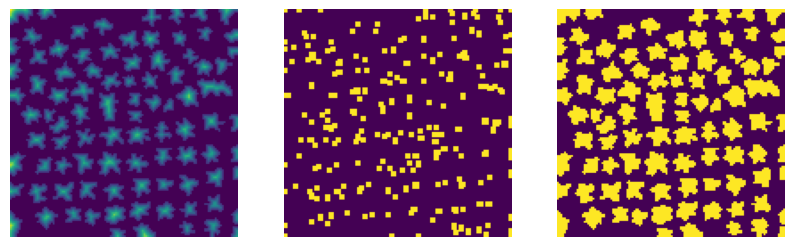

In [4]:
# MARKERS

def around(d, i, j):
    rs = d[
        max(i-1, 0):min(i+2, d.shape[0]),
        max(j-1, 0):min(j+2, d.shape[1])]

    return rs

d = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

peaks = np.zeros_like(d, dtype=np.uint8)

for i in range(d.shape[0]):
    for j in range(d.shape[1]):
        if d[i, j] == 0:
            continue

        z = around(d, i, j)

        if d[i, j] == z.max():
            peaks[i, j] = 1

peaks = cv2.dilate(peaks, KERN, iterations=1)
peaks[peaks != 0] = 255

# d = peaks

show(d, peaks, mask)
# show(d, labels=["Distance Transform", "Crown Centers"], show_axis=False, figsize=(20, 10))
# show(peaks, labels=["Crown Centers"], show_axis=False, figsize=(20, 10))
# show(mask, d, peaks, labels=["Mask", "Distance Transform", "Crown Centers"], show_axis=False, figsize=(20, 10))

In [5]:
# PREPARE
_, markers = cv2.connectedComponents(peaks)
markers += 1

unknown = cv2.subtract(mask, peaks)
markers[unknown != 0] = 0

# show(unknown, markers, labels=["Crown Centers", "Classified Peaks"], figsize=(20, 10))

# WATERSHED
watershed = cv2.watershed(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), markers)

s = cv2.imread(
    f"../data/satellite/images/{image_id}.tif")
s = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)

s[watershed == -1] = [255, 255, 0]

# show(s, watershed, labels=["Individual Tree Boundaries", "Individual Tree Segments"])#, show_axis=False, figsize=(20, 10))

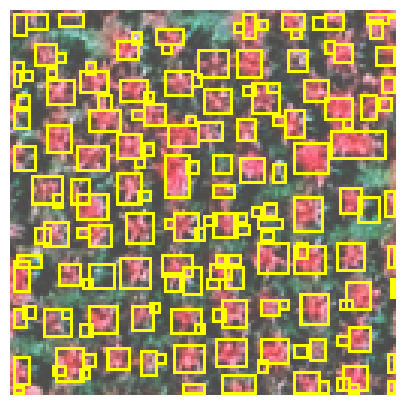

In [6]:
def rects(s):
    r = []

    for v in np.unique(s):
        if v <= 1:
            continue

        ct = cv2.findContours(
            (s == v).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)

        x, y, w, h = cv2.boundingRect(ct[0][0])
        r.append((x, y, w, h))

        # cv2.rectangle(r, (x, y), (x + w, y + h), 255)
    return r

simg = cv2.imread(
    f"../data/satellite/images/{image_id}.tif")
simg = cv2.cvtColor(simg, cv2.COLOR_BGR2RGB)

rects_ = rects(watershed)
for r in rects_:
    cv2.rectangle(simg, (r[0], r[1]), (r[0] + r[2], r[1] + r[3]), (255, 255, 0))

show(simg)#, show_axis=False, figsize=(20, 10))

## Bubble

In [7]:
import matplotlib.pyplot as pt
import matplotlib.pyplot
import numpy as np
import cv2
import json

from pathlib import Path
import glob
import os
import torch

def show(*args, labels=[], show_axis=False, figsize=(10, 5), save_to: str = None):
    l = len(args)

    if len(labels) < l:
        labels += [None] * (l - len(labels))

    fg, plots = pt.subplots(int(l ** .5), l // int(l ** .5), figsize=figsize)

    try:
        plots = plots.flatten()
    except:
        plots = [plots]

    for m, p, l in zip(args, plots, labels):
        ax: matplotlib.image.AxesImage = p.imshow(m)

        if not show_axis:
            ax.axes.axis('off')

        if l:
            ax.axes.title.set_text(l)

    if save_to is not None:
        pt.savefig(save_to, dpi=1000, bbox_inches="tight")

def drawbox(img, boxes, show_indices=False):
    img = img.copy()
    zoom = 1

    if show_indices:
        zoom = 3
        img = cv2.resize(img, np.array(img.shape[:2]) * zoom, interpolation=cv2.INTER_CUBIC)

    for i, box in enumerate(boxes):
        box = box.astype(int) * zoom
        cv2.rectangle(img, box[:2], box[2:], (255, 255, 0), 1)

        if show_indices:
            # x = int(box[[0, 2]].mean().item())
            x = int(box[0].item())
            y = int(box[[1, 3]].mean().item())

            cv2.putText(img, str(i), (x, y), cv2.FONT_HERSHEY_TRIPLEX, .3, (255, 255, 255), 1)

    return img

def fillbox(rimg, boxes, scores, dest=False):
    if not dest:
        rimg = rimg.copy()

    for box, score in sorted(zip(boxes, scores), key=lambda _: _[1], reverse=True):
        cv2.fillPoly(rimg, to_points(box.astype(int)).reshape(1, 4, 2), score, 1)

    return rimg

def readimg(path):
    img = cv2.imread(path)
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB, img)

    return img

def readjson(path):
    dt = json.load(open(path))

    return dt["box"]

def to_xywh(boxes):
    if boxes.ndim == 2:
        boxes = np.stack([boxes[:, 0], boxes[:, 1], boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]], axis=1)
        return boxes

    elif boxes.ndim == 1:
        return np.array([boxes[0], boxes[1], boxes[2] - boxes[0], boxes[3] - boxes[1]])

def to_points(boxes):
    if boxes.ndim == 2:
        boxes = np.stack([boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 1], boxes[:, 3], boxes[:, 0], boxes[:, 3]], axis=1)
        return boxes

    elif boxes.ndim == 1:
        return np.array([boxes[0], boxes[1], boxes[2], boxes[1], boxes[2], boxes[3], boxes[0], boxes[3]])


In [8]:
data_root_dir = Path("/Users/shreyas/Developer/Research/GroundingDINO/data/satellite")

images_dir = data_root_dir / "images"
masks_dir = data_root_dir / "masks"
boxes_dir = data_root_dir / "boxes"

pdata = {}

for f in glob.glob(str(boxes_dir / "*.json")):
    fname = os.path.basename(f)
    iid, _ = os.path.splitext(fname)

    pdata[iid] = [str(images_dir / f"{iid}.tif"), f]

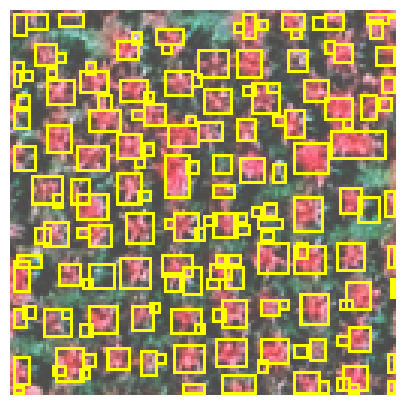

In [9]:
def filter_fn(box):
    w = box[:, 2] - box[:, 0]
    h = box[:, 3] - box[:, 1]

    th = 5
    return (w >= th) & (h >= th)

# image_f, boxes_f = pdata[image_id]
# image = readimg(image_f)
image = s_r.copy()
# sboxes = np.array(readjson(boxes_f), dtype=float)
sboxes = np.array([(x1, y1, x1 + x2, y1 + y2) for x1, y1, x2, y2 in rects_], dtype=float)
boxes = sboxes.copy()
# boxes = sboxes[filter_fn(sboxes)]

show(drawbox(image, sboxes))

In [ ]:
# def calc_scores(boxes):
#     h = boxes[:, 3] - boxes[:, 1]
#     w = boxes[:, 2] - boxes[:, 0]

#     # return ((w - h) / (w + h) + 1) / 2 *
#     ratio = (w - h) ** 2
#     ratio = ratio / ratio.max()

#     size = (w + h) ** 2
#     size = size / size.max()

#     rs = (size - ratio) * 1e3

#     # print(rs)
#     return rs

# calc_scores(np.array([[10, 0, 8, 20]]))

array([0.])

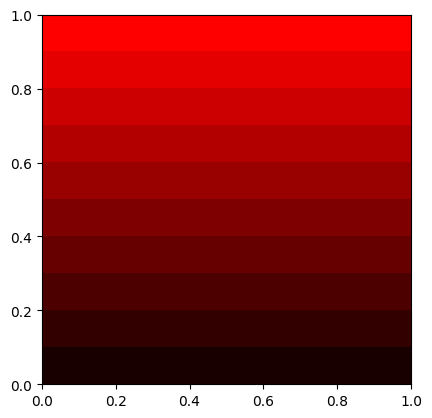

In [92]:
import matplotlib.pyplot as pt
import numpy as np
import cv2

m = np.zeros((100, 10, 3), dtype=np.float32)

for i in range(10):
    pts = np.array([
        [0, i * 10 + 0,   ],
        [0, i * 10 + 10,  ],
        [10, i * 10 + 10, ],
        [10, i * 10 + 0,  ],
    ], dtype=np.int32)

    cv2.fillPoly(m, [pts], 1 - (i / 10), 1)

pt.imshow(
    X=m,
    extent=(0, 1, 0, 1));

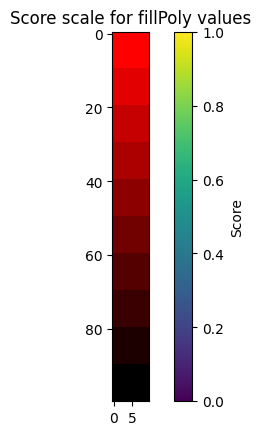

In [95]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

m = np.zeros((100, 10, 3), dtype=np.float32)

for i in range(10):
    pts = np.array([
        [0,  i * 10],
        [0,  i * 10 + 10],
        [10, i * 10 + 10],
        [10, i * 10],
    ], dtype=np.int32)

    value = 1 - (i / 9)   # values in [0, 1]
    cv2.fillPoly(m, [pts], value)


norm = mcolors.Normalize(vmin=0.0, vmax=1.0)

im = plt.imshow(
    m,
    cmap="viridis",     # IMPORTANT: matches grayscale fill
    norm=norm
)

plt.colorbar(im, label="Score")
plt.title("Score scale for fillPoly values")
plt.show()


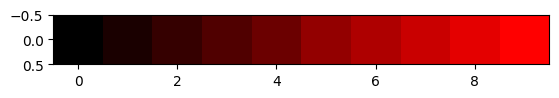

In [90]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
mat = np.indices((1,10))[1]
plt.imshow(mat, cmap=cm)
plt.show()

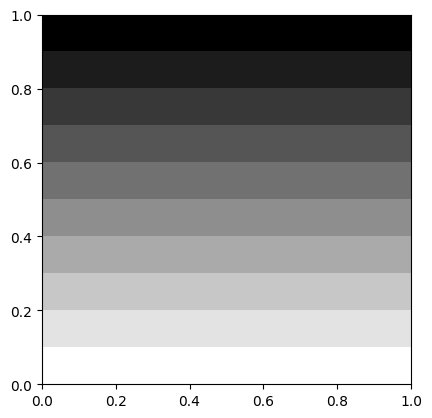

In [89]:
pt.imshow(
    m[:, :, 0],
    cmap="gray",
    vmin=0,
    vmax=1,
    extent=(0, 1, 0, 1),   # (xmin, xmax, ymin, ymax)
    origin="lower"
)

# pt.xlabel("X (normalized)")
# pt.xticks([])
# pt.yticks([])
# pt.ylabel("Y (normalized)")
# pt.colorbar(label="Score")
pt.show()


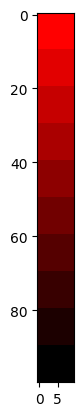

In [97]:
import matplotlib.pyplot as pt

scores = np.linspace(1., 0, 10)   # or any values you want

m = np.zeros((100, 10, 3), dtype=np.float32)

for i, score in enumerate(scores):
    pts = np.array([
        [0,  i*10],
        [0,  i*10 + 10],
        [10, i*10 + 10],
        [10, i*10],
    ], dtype=np.int32)

    cv2.fillPoly(m, [pts], score)

pt.imshow(m)

AttributeError: 'list' object has no attribute 'xlim'

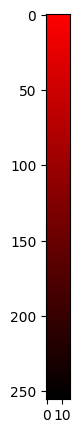

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def showx(*args, labels=[], show_axis=False, figsize=(10, 5), save_to: str = None):
    l = len(args)

    if len(labels) < l:
        labels += [None] * (l - len(labels))

    # fg, plots = pt.subplots(int(l ** .5), l // int(l ** .5), figsize=figsize)
    fg, plots = pt.subplots(1, l, figsize=figsize)

    try:
        plots = plots.flatten()
    except:
        plots = [plots]

    for m, p, l in zip(args, plots, labels):
        ax = p.imshow(m)
        # # plt.axis("off")

        if not show_axis:
            ax.axes.axis('off')

        if l:
            ax.axes.title.set_text(l)

    if save_to is not None:
        pt.savefig(save_to)


N = 256  # height
M = 16

# Create a gradient from 0 → 255
gradient = np.linspace(255, 0, N, dtype=np.uint8)

# Nx1 image, 3 channels (BGR for OpenCV)
img = np.zeros((N, M, 3), dtype=np.uint8)

# Set RED channel (OpenCV uses BGR)
for i in range(M):
    img[:, i, 2] = gradient  # Red increases top → bottom

# Convert BGR → RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

showx(img_rgb, show_axis=True)

# plt.imshow(img_rgb, extent=[0, 1, 0, 1], origin="upper")
# # plt.axis("off")
# plt.xlim(0, .1)
# plt.xticks([])


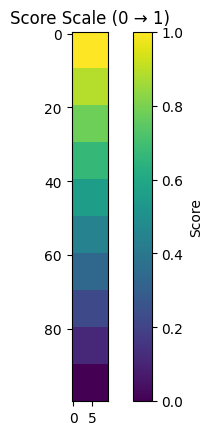

In [72]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

m = np.zeros((100, 10), dtype=np.float32)

for i in range(10):
    m[i*10:(i+1)*10, :] = 1 - (i / 9)   # values from 1 → 0

norm = mcolors.Normalize(vmin=0.0, vmax=1.0)

plt.imshow(m, cmap="viridis", norm=norm)
plt.colorbar(label="Score")
plt.title("Score Scale (0 → 1)")
plt.show()

(np.float64(-0.5), np.float64(9.5), np.float64(99.5), np.float64(-0.5))

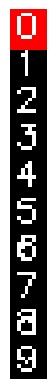

In [57]:
import matplotlib.pyplot as pt
import numpy as np
import cv2

m = np.zeros((100, 10, 3), dtype=np.float32)


for i in range(10):
    pts = np.array([
        [i * 10 + 0, 0,],
        [i * 10 + 10, 0,],
        [i * 10 + 10, 10,],
        [i * 10 + 0, 10,],
    ], dtype=np.int32)

    value = 1 - (i / 10)
    cv2.fillPoly(m, [pts], value, 1)

    # --- add numbering ---
    cv2.putText(
        m,
        str(i),                 # label
        (1, i * 10 + 7),        # (x, y) baseline
        cv2.FONT_HERSHEY_SIMPLEX,
        0.3,                    # font scale
        (1, 1, 1),              # white text
        1,
        cv2.LINE_AA
    )

pt.imshow(m)
pt.axis("off")


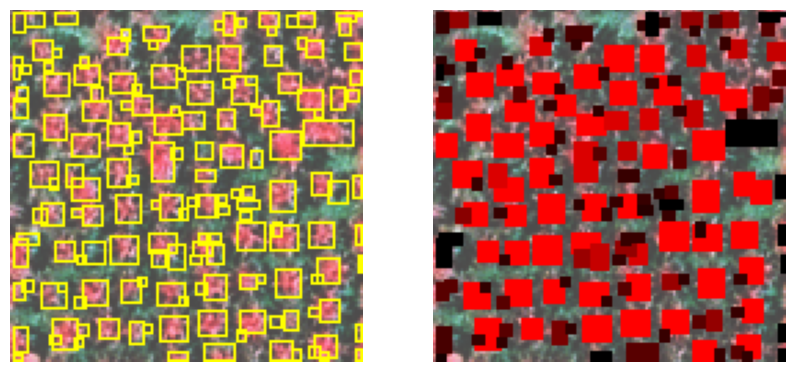

In [ ]:
def calc_scores(boxes):
    h = boxes[:, 3] - boxes[:, 1]
    w = boxes[:, 2] - boxes[:, 0]

    # return ((w - h) / (w + h) + 1) / 2 *
    ratio = (w - h) ** 2
    ratio = ratio / ratio.max()

    size = (w + h) ** 2
    size = size / size.max()

    rs = (size - ratio) * 1e3

    # print(rs)
    return rs
    # return (
    #     1 * (w - h) ** 2 +
    #     .1 * (w + h) ** 2)

def fillbox(rimg, boxes, scores, dest=False):
    if not dest:
        rimg = rimg.copy()

    for box, scr in sorted(zip(boxes, scores), key=lambda _: _[1], reverse=True):
        cv2.fillPoly(rimg, to_points(box.astype(int)).reshape(1, 4, 2), scr, 1)

    return rimg

scr = calc_scores(boxes)

show(drawbox(image, boxes), fillbox(image, boxes, scr))

/var/folders/rx/vyhzb7qs3j76hlfn_xm8z8zr0000gn/T/ipykernel_37884/3391581884.py:7: RuntimeWarning: invalid value encountered in divide
  ratio = ratio / ratio.max()


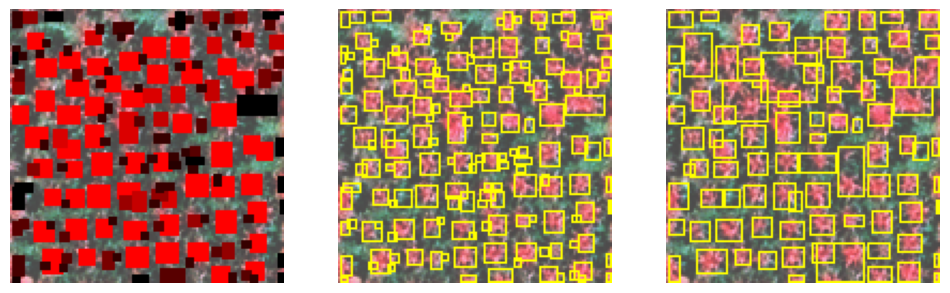

In [18]:
# neighbourhood graph

def neighbours(boxes, offset=0):
    ln = len(boxes)
    ns = np.zeros((ln, ln))

    for i, b1 in enumerate(boxes):
        for j, b2 in enumerate(boxes[i:], start=i):
            b10, b12 = min(b1[0], b1[2]), max(b1[0], b1[2])
            b11, b13 = min(b1[1], b1[3]), max(b1[1], b1[3])

            b20, b22 = min(b2[0], b2[2]), max(b2[0], b2[2])
            b21, b23 = min(b2[1], b2[3]), max(b2[1], b2[3])

            if not (
                (b10 - offset <= b20 <= b12 + offset and (b11 - offset <= b21 <= b13 + offset or b11 - offset <= b23 <= b13 + offset)) or
                (b10 - offset <= b22 <= b12 + offset and (b11 - offset <= b21 <= b13 + offset or b11 - offset <= b23 <= b13 + offset)) or
                (b20 - offset <= b10 <= b22 + offset and (b21 - offset <= b11 <= b23 + offset or b21 - offset <= b13 <= b23 + offset)) or
                (b20 - offset <= b12 <= b22 + offset and (b21 - offset <= b11 <= b23 + offset or b21 - offset <= b13 <= b23 + offset))
            ):
                continue

            ns[i, j] = ns[j, i] = 1
    return ns

def threshold_scores(boxes, threshold: int = 10):
    scores = calc_scores(boxes)
    return (scores > threshold).astype(float) * 255

def collapse(boxes):
    return np.array([
        boxes[:, 0].min(), boxes[:, 1].min(),
        boxes[:, 2].max(), boxes[:, 3].max()
    ])

def task(boxes, score_threshold: int = 100, neighbour_threshold: int = 1):
    scr = threshold_scores(boxes, score_threshold)

    sns = neighbours(boxes, neighbour_threshold)
    vis = np.zeros(sns.shape[0])

    res = []

    scr0, = np.where(scr == 0)

    for i in scr0:
        where, = np.where(sns[i] != 0)
        where = where[where != i]

        if not where.size:
            continue

        max_box = where[max(enumerate(calc_scores(boxes[where])), key=lambda _: _[1])[0]]

        if 1 in vis[[max_box, i]]:
            continue

        vis[[max_box, i]] = 1
        res.append(collapse(boxes[[max_box, i]]))

    res.extend(boxes[vis == 0])
    return np.array(res)

def task(boxes, score_threshold: int = 100, neighbour_threshold: int = 1):
    boxes = iou_collapse(boxes, threshold=.3)

    scr = threshold_scores(boxes, score_threshold)

    sns = neighbours(boxes, neighbour_threshold)
    vis = np.zeros(sns.shape[0])

    res = []

    scr0, = np.where(scr == 0)

    for i in scr0:
        where, = np.where(sns[i] != 0)
        where = where[where != i]

        if not where.size:
            continue

        max_box = where[max(enumerate(calc_scores(boxes[where])), key=lambda _: _[1])[0]]

        if 1 in vis[[max_box, i]]:
            continue

        vis[[max_box, i]] = 1
        res.append(collapse(boxes[[max_box, i]]))

    res.extend(boxes[vis == 0])
    res = np.array(res)

    return iou_collapse(res, .2)

def task_repeat(repeat, boxes, s_threshold: int = 180, n_threshold: int = 1):
    for i in range(repeat):
        boxes = task(boxes, s_threshold, n_threshold)

    return boxes

def calc_iou(b1, b2) -> float:
    """
    b1: (x1, y1, x2, y2)
    b2: (x1, y1, x2, y2)

    Returns IoU of the two bounding boxes.
    Coordinates are expected to be (top-left x, top-left y, bottom-right x, bottom-right y).
    """
    # Unpack coordinates
    x1_min, y1_min, x1_max, y1_max = b1
    x2_min, y2_min, x2_max, y2_max = b2

    # Calculate intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Compute width and height of the intersection box
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)

    # Area of intersection
    inter_area = inter_width * inter_height

    # Areas of the input boxes
    area_b1 = (x1_max - x1_min) * (y1_max - y1_min)
    area_b2 = (x2_max - x2_min) * (y2_max - y2_min)

    # Area of union
    union_area = area_b1 + area_b2 - inter_area

    # Compute IoU
    if union_area == 0:
        return 0.0
    return inter_area / union_area

def iou_collapse(boxes, threshold=.5):
    mask = np.zeros((boxes.shape[0], boxes.shape[0]), dtype=float)

    for i, b1 in enumerate(boxes):
        for j, b2 in enumerate(boxes[i+1:], start=i+1):
            mask[i, j] = calc_iou(b1, b2)

    res = []
    vis = []

    for i, m in enumerate(mask):
        if i in vis:
            continue

        c = m > threshold

        if True not in c:
            res.append(boxes[i])
        else:
            v, = np.where(c)
            vis.extend(v)

            res.append(collapse(boxes[v]))

    # print(True in (mask > .1))
    return np.array(res)

# iou_collapse(boxes).shape, boxes.shape
# show(drawbox(image, boxes), drawbox(image, iou_collapse(boxes)))
# True
boxes2 = task_repeat(4, boxes, 40, 1)
show(fillbox(image, boxes, scr), drawbox(image, boxes), drawbox(image, boxes2), figsize=(12, 5))#, labels=["Iteration 1", "Iteration 2"])

In [ ]:
boxes2

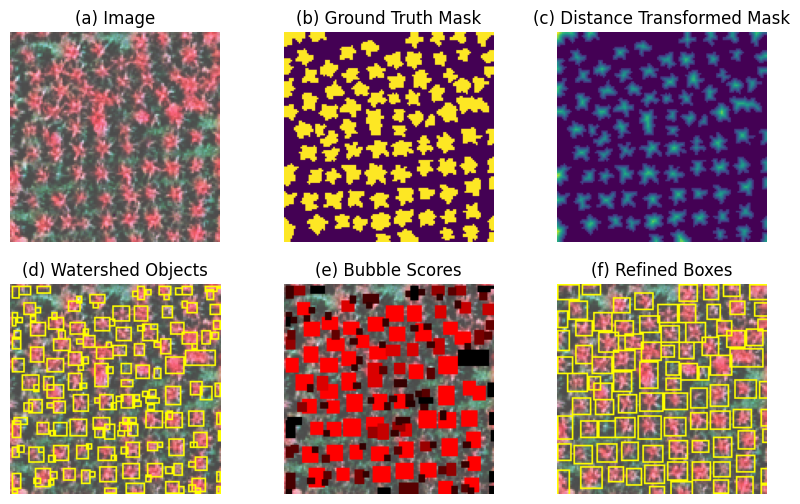

In [22]:
show(
    s_r, mask, d,
    drawbox(image, boxes), fillbox(image, boxes, scr), drawbox(image, boxes_msk),
    figsize=(10, 6),
    labels=[
        "(a) Image", "(b) Ground Truth Mask", "(c) Distance Transformed Mask",
        "(d) Watershed Objects", "(e) Bubble Scores", "(f) Refined Boxes"
    ],
    save_to=f"../outputs/preprocessing/{image_id}.png")

# image_id

## Metrics

bubble boxes: 42.280447894914126


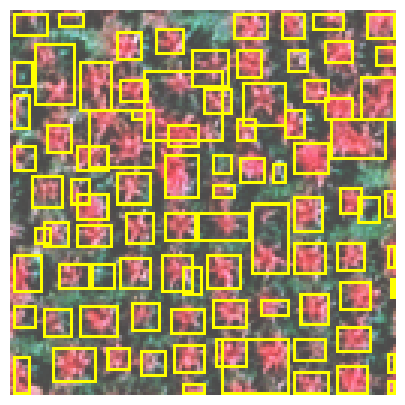

In [19]:
def clip_box(img, box):
    x1, y1, x2, y2 = box.astype(int)
    return img[y1:y2, x1:x2]

simg = s_r.copy()
boxs = boxes2.copy()

stdv_1 = []

for box in boxs:
    stdv_1.append(np.std(clip_box(simg, box)))

print("bubble boxes:", np.mean(stdv_1).item())
show(drawbox(simg, boxs))

raw boxes: 41.37544752088988


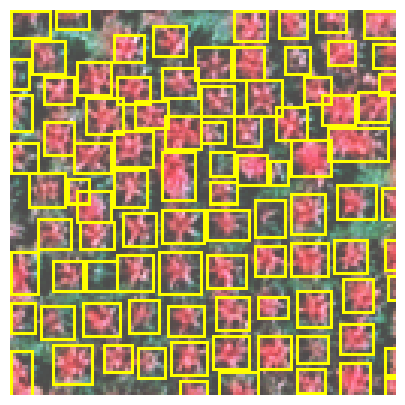

In [20]:
import cv2

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes_msk = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    boxes_msk.append((x, y, x+w, y+h))

boxes_msk = np.array(boxes_msk)

stdv_2 = []

for box in boxes_msk:
    stdv_2.append(np.std(clip_box(simg, box)))

print("raw boxes:", np.mean(stdv_2).item())
show(drawbox(simg, boxes_msk))